<img alt="Planet Labs logo" src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Planet_Labs_logo.svg" width="300">

# BatchV2 API Demo

## Documentation
---

You can find the official BatchV2 API documentation [**here**](https://docs.sentinel-hub.com/api/latest/api/batchv2/).
<br>
There is also an official migration guide on how to migrate from BatchV1 to V2 under this [**link**](https://docs.sentinel-hub.com/api/latest/api/batchv2/migration).

## Requirements
---

Before running this notebook, ensure that you have the following:
1. **Python**
2. Required Python packages:
   * [**Jupyter**](https://jupyter.org/)
   * [**Geopandas**](https://geopandas.org/en/stable/): A library used for working with geospatial data. We'll be using it to query and visualize GeoPackages.
   * [**Matplotlib**](https://matplotlib.org/): A plotting library.
   * [**Contextily**](https://github.com/geopandas/contextily): A library to add basemaps to our plots.
   * [**Shapely**](https://shapely.readthedocs.io/en/stable/#): A library for geometry operations.
   * [**Boto3**](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html): The AWS SDK we'll be using for downloading data from our S3 bucket.
   * [**Requests**](https://pypi.org/project/requests/). HTTP library.
3. **AWS account**
   * We need an AWS account and an S3 bucket. We'll be using it to provide our inputs and have BatchV2 deliver its outputs to our bucket.
     We will also be needing an IAM role that has granted the Sentinel Hub AWS account permissions to assume its role and have access to your bucket. Please refer to the official documentation for a detailed guide on how to do this.
4. **Sentinel Hub account**
   * Finally, we will need an Enterprise Sentinel Hub account and a Sentinel Hub OAuth client. More information about the client can be found later in the notebook. 

## Authentication

---

First, we need to acquire the access token so that we can execute requests against the Sentinel Hub services.

### Import Necessary Libraries

We'll start by importing the necessary libraries. In this notebook, we'll be using the `requests` library for executing all HTTP requests.


In [83]:
import requests
import base64
import os



### Grab some necessary environment variables

To get our Sentinel Hub access tokens, we need to get the credentials of our OAuth client.
This can be configured under `User settings` in the user's dashboard. A detailed guide on how to do that can be found [here](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/#registering-oauth-client).

Once we've set up our OAuth client, we can begin using it by extracting the `Client ID` and `Client Secret` into our code.

In [58]:
SH_CLIENT_ID = os.environ["SH_CLIENT_ID"]
SH_CLIENT_SECRET = os.environ["SH_CLIENT_SECRET"]

# This is the OAuth2 token endpoint where we'll get our tokens from
SH_TOKEN_URL = 'https://services.sentinel-hub.com/oauth/token'

### Requesting and extracting the token

We use the client credentials flow to request a token from the OAuth2 service. We'll handle this using a POST request to the `SH_TOKEN_URL`.


In [84]:
# We need to encode the credentials in base64 in the format of "client_id:client_secret"
def encode_client_credentials(client_id, client_secret):
    credentials = f'{client_id}:{client_secret}'
    encoded_credentials = base64.b64encode(credentials.encode()).decode()
    return encoded_credentials

encoded_credentials = encode_client_credentials(SH_CLIENT_ID, SH_CLIENT_SECRET)

In [85]:
# Requesting the token
def get_oauth2_token(encoded_credentials, token_url):
    headers = {
        'Authorization': f'Basic {encoded_credentials}',
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    data = {
        'grant_type': 'client_credentials'
    }
    response = requests.post(token_url, headers=headers, data=data)
    if response.status_code == 200:
        return response.json()['access_token']
    else:
        response.raise_for_status()
# Get the token from the token endpoint
access_token = get_oauth2_token(encoded_credentials, SH_TOKEN_URL)

## Running a BatchV2 task with GeoPackage as input
---
In this example, we'll run a simple task that renders RGB raster data around the coast of Australia. To achieve this, we'll use a new feature of BatchV2, providing GeoPackage as input for our BatchV2 task. 

> **Please note that we will not be visualizing the raster results of the processing directly in this notebook.**

### Exploring our input GeoPackage


In [86]:
# Import the necessary libraries
import geopandas as gpd
import matplotlib.pyplot as plt

gdf_input_gpkg = gpd.read_file("australian_coastline.gpkg")

# Print the contents of the gpkg feature table
gdf_input_gpkg.head()


,id,identifier,width,height,resolution,geometry
0,41,COAST_41,None,None,0.001,"POLYGON ((114.00000 -30.00000, 112.00000 -30.0..."
1,42,COAST_42,None,None,0.001,"POLYGON ((114.00000 -28.00000, 112.00000 -28.0..."
2,43,COAST_43,None,None,0.001,"POLYGON ((114.00000 -26.00000, 112.00000 -26.0..."
3,44,COAST_44,None,None,0.001,"POLYGON ((114.00000 -24.00000, 112.00000 -24.0..."
4,45,COAST_45,None,None,0.001,"POLYGON ((114.00000 -22.00000, 112.00000 -22.0..."


The input GeoPackage must have at least a single feature table with the following columns:
* id (corresponds to \<tileId> in the output path template)
* identifier (corresponds to \<tileName> in the output path template)
* width
* height
* resolution

It must also have a geometry column, but that one be named arbitrarily.
The GeoPackage must also specify for each feature table what CRS the features are in.

Text(0.5, 1.0, 'GeoPackage Features')

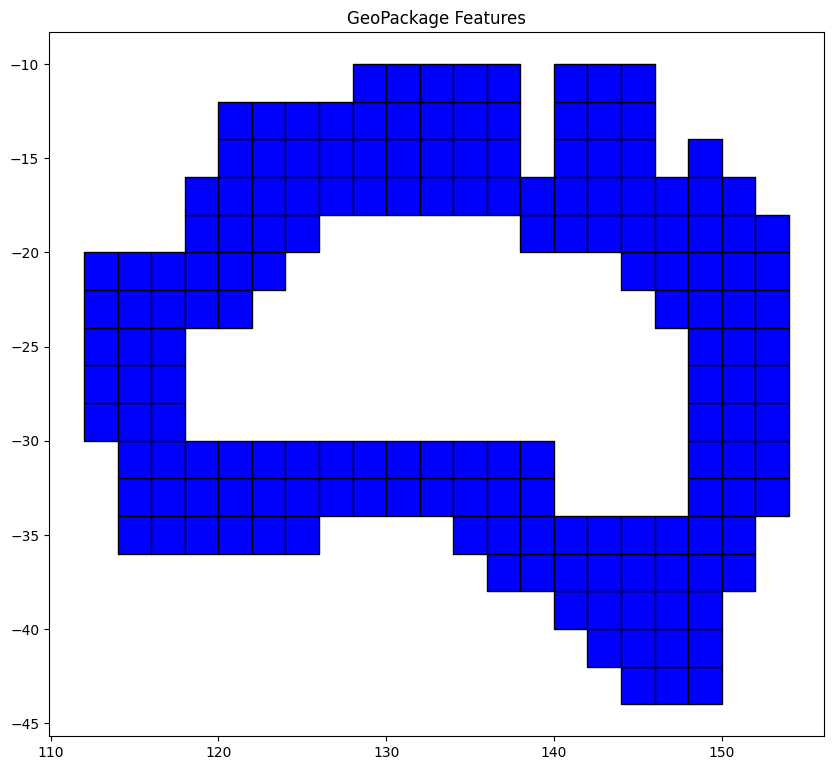

In [87]:
# Plotting the features
_, ax_input_gpkg = plt.subplots(figsize = (10, 10))

gdf_input_gpkg.plot(ax = ax_input_gpkg, color = 'blue', edgecolor = 'black')

ax_input_gpkg.set_title('GeoPackage Features')

Text(0.5, 1.0, 'Australian Coastline GeoPackage features with map')

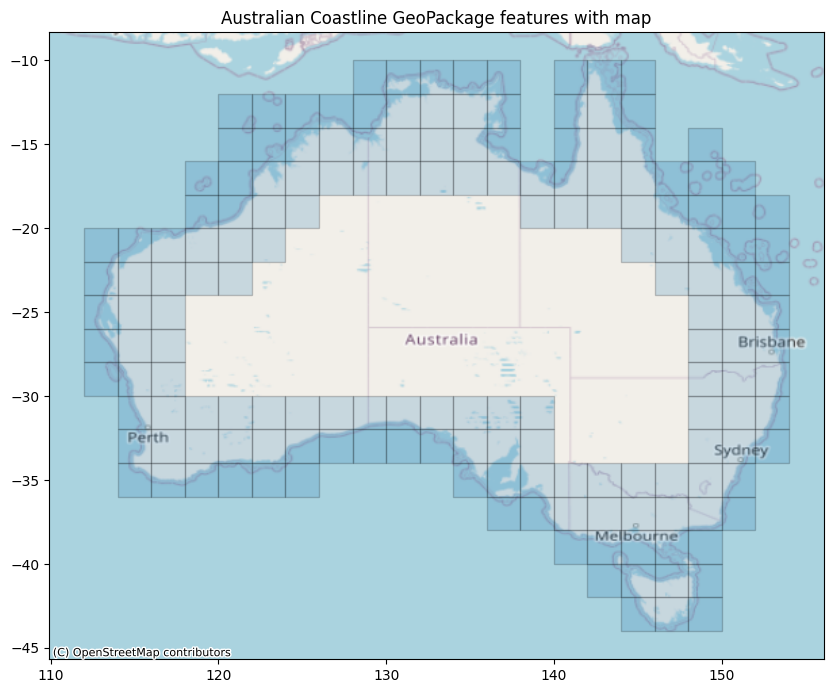

In [88]:
# Plotting the features on a map
import contextily as ctx

_, ax_input_gpkg = plt.subplots(figsize=(10, 10))
gdf_input_gpkg.plot(ax = ax_input_gpkg, alpha = 0.2, edgecolor = 'k')

# Add the basemap
ctx.add_basemap(ax_input_gpkg, crs = gdf_input_gpkg.crs.to_string(), source = ctx.providers.OpenStreetMap.Mapnik)

ax_input_gpkg.set_title('Australian Coastline GeoPackage features with map')

### Defining the BatchV2 request body

In [64]:
# Define your own IAM role ARN!
AWS_IAM_ROLE_ARN = "<your-iam-role-arn>"
GEOPACKAGE_S3_URI = "<your-path-to-gpkg-on-s3-bucket>" #e.g. s3://my-bucket//my-path-to-input-geopackage.gpkg

# Define the bounding box coordinates. This will be used to filter out features that do not intersect with this bbox.
bbox = [108, -45, 158, -4]
bounds_json = {
    "bbox": bbox
}

description = "BatchV2 - Australian coastline GeoPackage in RGB demo"

In [65]:
request_body = {
    "processRequest" : {
        "input": {
            "data": [
                {
                    "type": "S2L2A",
                    "dataFilter": {
                        "timeRange": {
                            "to": "2023-12-31T23:59:59Z",
                            "from": "2023-01-01T00:00:00Z"
                        },
                        "mosaickingOrder": "mostRecent",
                        "maxCloudCoverage": 5.0
                    }
                }
            ],
            "bounds": bounds_json
        },
        "output": {
            "responses": [
                {
                    "identifier": "default",
                    "format": {
                        "type": "image/tiff"
                    }
                }
            ]
        },
        "evalscript": "//VERSION=3\n\nfunction setup() {\n  return {\n    input: [\"B02\", \"B03\", \"B04\"],\n    output: { bands: 3 }\n  };\n}\n\nfunction evaluatePixel(sample) {\n  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];\n}"
    },
    "description" : description,
    "input": {
        "type": "geopackage",
        "features": {
            "s3": {
                "url": GEOPACKAGE_S3_URI,
                "iamRoleARN": AWS_IAM_ROLE_ARN
            }
        }
    },
    "output" :  {
        "type": "raster",
        "delivery": {
            "s3": {
                "url": "s3://batchv2-demo/requests/australian-coastline/<requestId>/<tileName>_<outputId>.<format>",
                "iamRoleARN": AWS_IAM_ROLE_ARN
            }
        },
        "cogOutput": "true"
    }
}

### Plotting the AOI

Text(0.5, 1.0, 'Bounding box of the request')

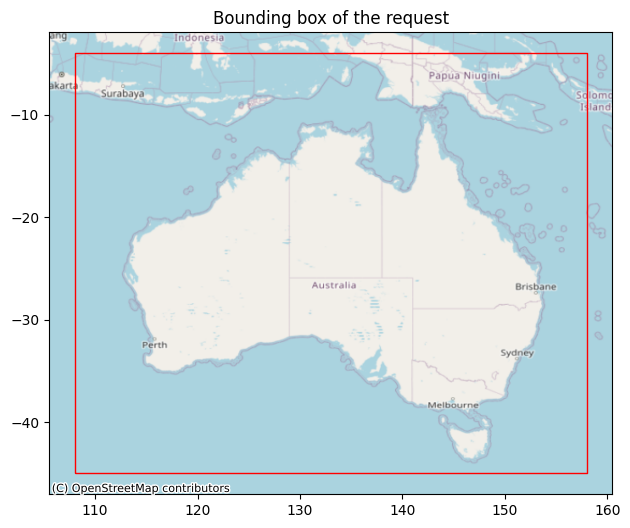

In [89]:
from shapely.geometry import Polygon

# Create a Polygon from the bounding box coordinates
bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])

# Create a GeoDataFrame with the bounding box Polygon
gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs="EPSG:4326")

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, facecolor='none', edgecolor='red')

# Add map
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set plot title and display
plt.title('Bounding box of the request')

### Executing the request on BatchV2

In [67]:
# Let's start by creating the task with the request body we've defined earlier
SH_BATCH_V2_CREATE_TASK_URL = "https://services.sentinel-hub.com/api/v2/batch/" + "process"

auth_headers = {
    'Authorization': f'Bearer {access_token}'
}
response = requests.post(SH_BATCH_V2_CREATE_TASK_URL, json = request_body, headers = auth_headers)

# Check if the request was successful (status code 201 - CREATED)
if response.status_code == 201:
    response_json = response.json()
    task_id = response_json['id']
    print(f'Request was successful! Created task ID: {task_id}')
else:
    print('Request failed with status code:', response.status_code)
    print('Response:', response.text)

Request was successful! Created task ID: 502ad690-906c-4b71-8050-87476611ec6b


In [68]:
# display JSON interactively
from IPython.display import JSON

JSON(response_json)

<IPython.core.display.JSON object>

In [69]:
# First, we can start the analysis. Alternatively, we can call the start endpoint immediately and it will start the analysis for us automatically.

SH_BATCH_V2_ANALYSE_TASK_URL = "https://services.sentinel-hub.com/api/v2/batch/process/" + task_id + "/analyse"

response = requests.post(SH_BATCH_V2_ANALYSE_TASK_URL, headers = auth_headers)
# Check if the request was successful (status code 204 - No Content)
if response.status_code == 204:
    print('Request for analysis was successful!')
else:
    print('Request failed with status code:', response.status_code)
    print('Response:', response.text)

Request for analysis was successful!


In [72]:
# Check if the analysis is already finished...

SH_BATCH_V2_GET_TASK_URL = "https://services.sentinel-hub.com/api/v2/batch/process/" + task_id

response = requests.get(SH_BATCH_V2_GET_TASK_URL, headers = auth_headers)
if response.ok:
    print('Get request was successful!')
    response_json = response.json()
else:
    print('Request failed with status code:', response.status_code)
    print('Response:', response.text)

JSON(response_json)

Get request was successful!


<IPython.core.display.JSON object>

### FeatureManifest

Once the analysis is finished, BatchV2 will upload a file called the Feature Manifest file. This file contains all the features that will be processed and their associated metadata, in the format of a GeoPackage.

The exact schema of this file can be found in the [documentation](https://docs.sentinel-hub.com/api/latest/api/batchv2/#feature-manifest).

The output path of this file depends on your output delivery path defined in your request. The file will be located in the "root" path of the template. For example, our template was:

`s3://batchv2-demo/requests/australian-coastline/<requestId>/<tileName>_<outputId>.<format>`

meaning the root path of our template would be:

`s3://batchv2-demo/requests/australian-coastline/<requestId>`

and the feature manifest file would be located at:

`s3://batchv2-demo/requests/australian-coastline/<requestId>/featureManifest-<requestId>.gpkg`


In [90]:
# need to import and configure our s3 client
import boto3

AWS_ACCESS_SECRET_KEY = os.environ["AWS_SECRET_ACCESS_KEY"]
AWS_ACCESS_KEY = os.environ["AWS_ACCESS_KEY_ID"]
AWS_BUCKET = "batchv2-demo"

s3_client = boto3.client(
    's3',
    aws_access_key_id = AWS_ACCESS_KEY,
    aws_secret_access_key = AWS_ACCESS_SECRET_KEY
)

In [91]:
#  define the path of our feature manifest file
feature_manifest_s3_key_uri = "requests/australian-coastline/" + task_id + "/featureManifest-" + task_id + ".gpkg"
feature_manifest_local_file_path = "feature_manifest.gpkg"

s3_client.download_file(AWS_BUCKET, feature_manifest_s3_key_uri, feature_manifest_local_file_path)

In [92]:
gdf_manifest = gpd.read_file(feature_manifest_local_file_path)

gdf_manifest.head()

,id,identifier,outputId,path,width,height,geometry
0,41,COAST_41,default,s3://batchv2-demo/requests/australian-coastlin...,2000,2000,"POLYGON ((114.00000 -30.00000, 112.00000 -30.0..."
1,42,COAST_42,default,s3://batchv2-demo/requests/australian-coastlin...,2000,2000,"POLYGON ((114.00000 -28.00000, 112.00000 -28.0..."
2,43,COAST_43,default,s3://batchv2-demo/requests/australian-coastlin...,2000,2000,"POLYGON ((114.00000 -26.00000, 112.00000 -26.0..."
3,44,COAST_44,default,s3://batchv2-demo/requests/australian-coastlin...,2000,2000,"POLYGON ((114.00000 -24.00000, 112.00000 -24.0..."
4,45,COAST_45,default,s3://batchv2-demo/requests/australian-coastlin...,2000,2000,"POLYGON ((114.00000 -22.00000, 112.00000 -22.0..."


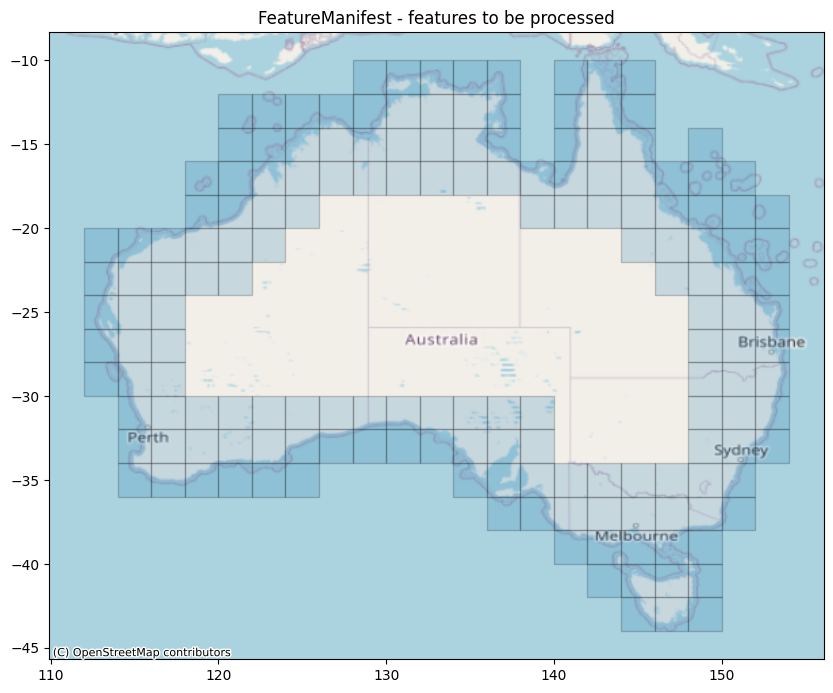

In [93]:
# Plot the features with a basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the geospatial data
gdf_manifest.plot(ax = ax, alpha = 0.2, edgecolor = 'k')

# Add the basemap
ctx.add_basemap(ax, crs = gdf_manifest.crs.to_string(), source = ctx.providers.OpenStreetMap.Mapnik)

# Set plot title
ax.set_title('FeatureManifest - features to be processed')

# Show the plot
plt.show()

### Starting the task


In [77]:
SH_BATCH_V2_START_TASK_URL = "https://services.sentinel-hub.com/api/v2/batch/process/" + task_id + "/start"

response = requests.post(SH_BATCH_V2_START_TASK_URL, headers = auth_headers)
# Check if the request was successful (status code 204 - No Content)
if response.status_code == 204:
    print('Request for starting the task was successful!')
else:
    print('Request failed with status code:', response.status_code)
    print('Response:', response.text)

Request for starting the task was successful!


#### Check the current status of the task

In [79]:
SH_BATCH_V2_GET_TASK_URL = "https://services.sentinel-hub.com/api/v2/batch/process/" + task_id

response = requests.get(SH_BATCH_V2_GET_TASK_URL, headers = auth_headers)
if response.ok:
    print('Get request was successful!')
    response_json = response.json()
else:
    print('Request failed with status code:', response.status_code)
    print('Response:', response.text)

JSON(response_json)

Get request was successful!


<IPython.core.display.JSON object>

### Execution SQLite Database

We can continuously poll the task status via the previous API call. However, we can also use the Execution DB to track progress on individual features. The file is uploaded periodically to the S3 bucket. 

The schema of this file can also be found in the [documentation](https://docs.sentinel-hub.com/api/latest/api/batchv2/#execution-database).

#### Download the Execution DB using boto3

In [81]:
from botocore.exceptions import ClientError

# Execution DB will be located in the root folder, named "execution-<requestId>.sqlite"
execution_db_s3_key_uri = "requests/australian-coastline/" + task_id + "/execution-" + task_id + ".sqlite"
execution_db_local_file_path = "execution.sqlite"

try:
    s3_client.download_file(AWS_BUCKET, execution_db_s3_key_uri, execution_db_local_file_path)
    print("Execution DB downloaded!")
except ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("File not found. Execution DB has not been uploaded yet...")
    else:
        raise  # Raise the exception if it's not a 404 error

Execution DB downloaded!


#### Query the Execution DB

We can run a simple query just to see a summary of how many features are in each status.

In [82]:
import sqlite3

# Open a connection to the Execution DB using sqlite3
con = sqlite3.connect(execution_db_local_file_path)

# Grab a cursor
cur = con.cursor()

# Query to count occurrences of each status of all features.
status_counts_query = """
    SELECT status, COUNT(*) AS count
    FROM features
    GROUP BY status;
"""

# Execute the query
cur.execute(status_counts_query)

# Fetch all the results
status_counts = cur.fetchall()

# Print the summary
print("Summary of feature statuses:")
for status, count in status_counts:
    print(f"{status}: {count} feature(s)")

Summary of feature statuses:
DONE: 167 feature(s)


### Conclusion

Once all features are marked as `DONE`, we can download them from the S3 bucket and visualize the results in our program of choice